In [1]:
"""
FEniCS tutorial demo program: Incompressible Navier-Stokes equations
for channel flow (Poisseuille) on the unit square using the
Incremental Pressure Correction Scheme (IPCS).

  u' + u . nabla(u)) - div(sigma(u, p)) = f
								 div(u) = 0
"""

from __future__ import print_function
from fenics import *
from mshr import *
import numpy as np
import matplotlib.pyplot as plt

In [30]:
T = 10.0           # final time
num_steps = 1    # number of time steps
dt = T / num_steps # time step size
mu = 1             # kinematic viscosity
rho = 1            # density

To create a Mesh, either use one of the built-in meshes https://fenicsproject.org/docs/dolfin/1.4.0/python/demo/documented/built-in_meshes/python/documentation.html or create a custom one. 

Notice that the class PolygonalMeshGenerator has been deprecated so it's no longer available. Instead, we need to call generate_mesh on a custom domain. Custom domains are generated by combining through union, intersection or difference elementary shapes. Custom meshes require the package mshr https://bitbucket.org/benjamik/mshr/src/master/ , which comes if FEniCS is installed system-wide (i.e. through apt, not through Anaconda). Elementary shapes are, which are dolfin.Point, Rectangle, Circle, Ellipse, Polygon: https://bitbucket.org/benjamik/mshr/wiki/browse/API

The two next cells are **alternatives** implementing a built-in mesh over a unit square or custom one.

In [31]:
# Create mesh
mesh = UnitSquareMesh(16, 16)

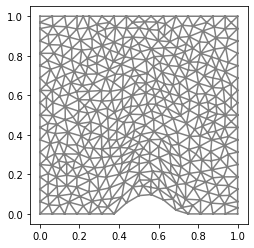

In [88]:
domain = Rectangle(Point(0., 0.), Point(1., 1.))  
         #Circle(dolfin.Point(0.5, 0.0), 0.1) - \
         #Rectangle(dolfin.Point(0.0, 0.9), dolfin.Point(0.4, 1.0)) 

mesh = generate_mesh(domain, 16, "cgal")

def DeformMeshCoords(mesh):
    x = mesh.coordinates()[:, 0]
    y = mesh.coordinates()[:, 1]
    
    new_y = [y[i] + 0.1*np.sin(3*pi*(x[i]-(3/8)))*(1-y[i]) if(x[i] < 0.75 and x[i] > 0.3) else 0 for i in range(len(y)) ]
    y = np.maximum(y, new_y)

    mesh.coordinates()[:] = np.array([x, y]).transpose()
    return mesh

new_mesh = DeformMeshCoords(mesh)
#new_mesh = generate_mesh(new_mesh, 16, "cgal")

plot(mesh)

In [89]:
# Define function spaces
V = VectorFunctionSpace(mesh, 'P', 2)
Q = FunctionSpace(mesh, 'P', 1)

What follows is an example of a custom Expression for a boundary.

Obs. that "Custom expressions defined in Python are no longer subclasses of Expression (as documented in https://fenicsproject.org/docs/dolfin/1.6.0/python/programmers-reference/functions/expression/Expression.html), but, instead, of a separate class, UserExpression". That's why class `class MyExpression(Expression)` must be
`class MyExpression(UserExpression)` instead.

In [103]:
# Define boundaries
left  = 'near(x[0], 0)'
right = 'near(x[0], 1)'
above = 'near(x[1], 1)'
below = 'near(x[1], 0)'

def bottom_boundary(x, on_boundary):
    if(near(x[1], 0.1*np.sin(3*pi*(x[0]-(3/8)))*(1-x[1])) and on_boundary and (x[0] < 0.75 and x[0] > 0.3)):
        return True
    elif(near(x[1], 0) and on_boundary and (x[0] >= 0.75 and x[0] <= 0.3)):
        return True
    else:
        False

#def top_boundary(x, on_boundary):
#    return True if (near(x[1], 1.1*np.sin(2*pi*x[0])) and on_boundary) else False

# Define boundary conditions
ux_sin = Expression(("-sin(2*pi*x[1])", 0), degree = 2)
#ux_linear = Expression(('x[1]-(1/2)', 0), degree = 2)
bcu_right = DirichletBC(V, ux_sin, right)
bcu_left  = DirichletBC(V, Constant((0.0, 0.0)), left)
bcu_above = DirichletBC(V, Constant((0.0, 0.0)), above)
bcu_below  = DirichletBC(V, Constant((0.0, 0.0)), bottom_boundary)

#bcp_above = DirichletBC(Q, Constant(0), 'near(x[0], 1) && near(x[1], 1)')
#bcp_below = DirichletBC(Q, Constant(0), below)

#Group them together for later usage
bcu = [bcu_right, bcu_left, bcu_above, bcu_below]
bcp = []

In [116]:
# Define trial and test functions
u = TrialFunction(V)
v = TestFunction(V)
p = TrialFunction(Q)
q = TestFunction(Q)

# Define functions for solutions at previous and current time steps
u_n = Function(V)
u_  = Function(V)
p_n = Function(Q)
p_  = Function(Q)

# Define expressions used in variational forms
U   = 0.5*(u_n + u)
n   = FacetNormal(mesh)
g   = 9.81
f   = Constant((0, -g))
k   = Constant(dt)
mu  = Constant(mu)
rho = Constant(rho)

In [117]:
# Define strain-rate tensor
def epsilon(u):
	return sym(nabla_grad(u))

# Define stress tensor
def sigma(u, p):
	return 2*mu*epsilon(u) - p*Identity(len(u))

In [118]:
# Define variational problem for step 1
F1 = rho*dot((u - u_n) / k, v)*dx + \
     rho*dot(dot(u_n, nabla_grad(u_n)), v)*dx \
     + inner(sigma(U, p_n), epsilon(v))*dx \
     + dot(p_n*n, v)*ds - dot(mu*nabla_grad(U)*n, v)*ds \
     - dot(f, v)*dx
a1 = lhs(F1)
L1 = rhs(F1)

# Define variational problem for step 2
a2 = dot(nabla_grad(p), nabla_grad(q))*dx
L2 = dot(nabla_grad(p_n), nabla_grad(q))*dx - (1/k)*div(u_)*q*dx

# Define variational problem for step 3
a3 = dot(u, v)*dx
L3 = dot(u_, v)*dx - k*dot(nabla_grad(p_ - p_n), v)*dx

In [119]:
# Assemble matrices
A1 = assemble(a1)
A2 = assemble(a2)
A3 = assemble(a3)

# Apply boundary conditions to matrices
[bc.apply(A1) for bc in bcu]
[bc.apply(A2) for bc in bcp]

[]

In [120]:
# Time-stepping
t = 0
for n in range(num_steps):
    t += dt

    # Step 1: Tentative velocity step
    b1 = assemble(L1)
    [bc.apply(b1) for bc in bcu]
    solve(A1, u_.vector(), b1)

    # Step 2: Pressure correction step
    b2 = assemble(L2)
    [bc.apply(b2) for bc in bcp]
    solve(A2, p_.vector(), b2)

    # Step 3: Velocity correction step
    b3 = assemble(L3)
    solve(A3, u_.vector(), b3)

    # Compute error
    u_e = Expression(('4*x[1]*(1.0 - x[1])', '0'), degree=2)
    u_e = interpolate(u_e, V)
    error = np.abs(u_e.vector().get_local() - u_.vector().get_local()).max()
    #print('t = %.2f: error = %.3g' % (t, error))
    #print('max u:', u_.vector().get_local().max())

    # Update previous solution
    u_n.assign(u_)
    p_n.assign(p_)    

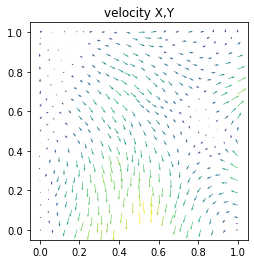

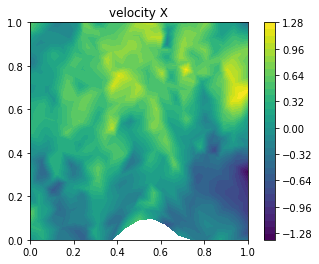

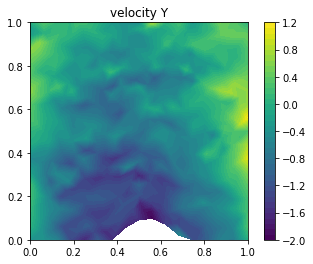

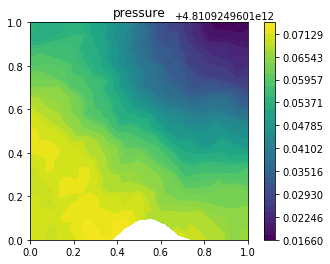

In [121]:
# Plot solution
#fig = plt.figure(figsize=(80, 60))

fig = plot(u_, title='velocity X,Y')
plt.show()

fig = plot(u_[0], title='velocity X')
plt.colorbar(fig)
plt.show()

fig = plot(u_[1], title='velocity Y')
plt.colorbar(fig)
plt.show()

fig = plot(p_, title='pressure')
plt.colorbar(fig)
plt.show()


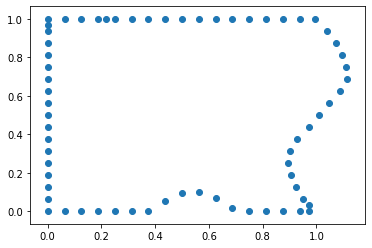

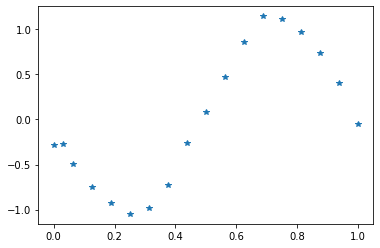

In [102]:
_u_1, _u_2 = u_.split(True)
_u_1 = u_.sub(0)

bmesh = BoundaryMesh(mesh, "exterior", True)
boundarycoords=bmesh.coordinates()

rightboundary=[]
xvelrightboundary=[]
BC = np.empty(shape=(len(boundarycoords), 2)) #https://stackoverflow.com/a/569063
for i in range(len(boundarycoords)):
    
    if boundarycoords[i][0]==1:
        BC[i][1] = boundarycoords[i][1]
        BC[i][0] = (_u_1(boundarycoords[i]))/10+1
    else:
        BC[i][0] = boundarycoords[i][0]
        BC[i][1] = boundarycoords[i][1]

fig6=plt.figure()
plt.scatter(BC[:,0], BC[:,1])
plt.show()

#plt.scatter(boundarycoords[:,0], boundarycoords[:,1])

_u_1, _u_2 = u_.split(True)

bmesh = BoundaryMesh(mesh, "exterior", True)   ########
boundarycoords=bmesh.coordinates()

rightboundary=[]
xvelrightboundary=[]
for point in boundarycoords:
    if point[0]==1:
        rightboundary.append(point[1])
        xvelrightboundary.append(_u_1(point[0:2]))

fig5=plt.figure()
plt.plot(rightboundary,xvelrightboundary,'*')